<div align="center">
    <h1>Data Analysis of AbberZip: The Results of A Psycholinguistics Experiment</h1>
</div>

## Background
### Generalizations
Imagine you're learning a new language. You think you're finally starting to understand the rules for certain conjugations. For example, in Spanish, article assignment is based on the masculinity or femininity of the word. Most masculine words end in -o, and most feminine words end in -a, so it would be reasonable to assume that 'gato' is paired with 'el,' and 'luna' is paired with 'la.' 

### Exceptions
But suddenly, you're faced with 'el mapa,' or 'la mano.' These exceptions to the rule you have in your head completely throw you off. 

But do the exceptions get stronger, or does the generalization get weaker? Or do you scrap the generalization out entirely and subconsciously decide to use rote memorization for every term? 

The AbberZip experiment created by UIUC's Dr. Karina Tachihara investigates this competition between generalizations and exceptions. For more detailed information, please visit the link below to read the original research paper. 

__[A Generalization Becomes Suppressed Over Time in the Context of Exceptions](https://escholarship.org/content/qt82x8c04s/qt82x8c04s_noSplash_58ab61cf9074d73a890585be5e003c37.pdf?t=sgiuiq)__

### Hypothesis 
The possibility that this experiment investigates is that generalizations become suppressed when faced with exceptions. We have reason to believe that competition between memories drives learning based on previous research. For example, consider the examples derived from the experiments of Anderson et al. below: 

### Example 1
Imagine I present you with 3 words in 2 categories: 

Animals
* dog
* cat
* bird

Beverages
* soda
* tea
* water

Pretend I've had you memorize each word in each category. When I present you with a cue like (animal: d___) and ask you to predict the word, you would guess 'dog.' Understand that the semantic category 'animal' would also initially activate 'cat,' and 'bird.' However, once you see 'd,' you understand that 'dog' is the only correct possibility. This is a competitive process; 'dog' wins in a competition between 'cat' and 'bird.' 

Upon futher testing, I would unsurprisingly find that you will best recall the words you practiced most (i.e. 'dog'). Interestingly enough, the words you didn't practice would have different recall rates depending on their category. The words in the same category as the most-practiced word (i.e. 'cat' and 'bird') would have a lower recall rate than untouched baseline items in the other category (beverages). 

This effect is known as retrieval-induced forgetting (RIF).  

### Experiment 2
Imagine I present you with the same sets of words, except now, pretend that I have you repeat the word 'dog,' but I don't provide you with any cues as I did in the previous example. This process would partially activate other items in the same category ('cat' and 'bird') without suppressing them. Instead, 'cat' and 'bird' would be equally likely to be recalled as baseline items (beverages). Why is this? 

The cue introduces competition. Anderson et al., (2000) found that competition plays a major role in the retrieval process. 

Therefore, it is not merely the strengthening of the more activated memory that resolves the competition. Rather, competition also leads to suppression of the less activated memory. In Anderson's examples, practicing 'dog' with a cue suppressed other objects in the same category like 'cat' and 'bird.' Similarly, in the AbberZip experiment, participants will learn a general rule (e.g., the prefix 'abber' usually applies to faces). Over time, as they learn exceptions (e.g., 'abber' now applies to a room), the general rule ('abber = face') doesn't just weaken, it actually becomes actively *suppressed* due to consistent competition with the exception.

![image info](./images/abberzip_example.png)

This can be likened to how 'cat' and 'bird' are suppressed through competition with 'dog' when cues are present. The deviation of mouse trajectories toward the incorrect (generalized) choice is evidence of this effect. As the experiment progresses, we expect less deviation, indicating suppression of the general rule in favor of the exception: an example of retrieval-induced forgetting. 

__[Works Cited](https://github.com/rrgreen77/bcog-final-abberzip-data-analysis/edit/main/works_cited.md)__



***
# Step 1: 
### Amalgamate data from 3 separate files (runInfo, clickData, trackAllData) and put it into a master spreadsheet with all particpants. This spreadsheet will contain: 

* participant
* block_num (only blocks 2 and 7 included)
* trial_count
* trial_type
* accuracy
* correct_stimulus_side
* click_x and click_y
    * the mouse position position where the user clicked the stimulus
* all mousetracking data (needed to help us plot the mouse's path):
    * reaction time
    * each x position 
    * each y position

***

In [1]:
# IMPORTS #
%reset -f
import pandas as pd
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import simpson
from scipy import stats

# DISCLAIMER: Please note that I used the help of ChatGPT for various functions when I was unsure about how to achieve specific things that were not discussed in class, namely: amalgamating the 3 spreadsheets, interpolation for plotting the average mouse trajectories, and ...

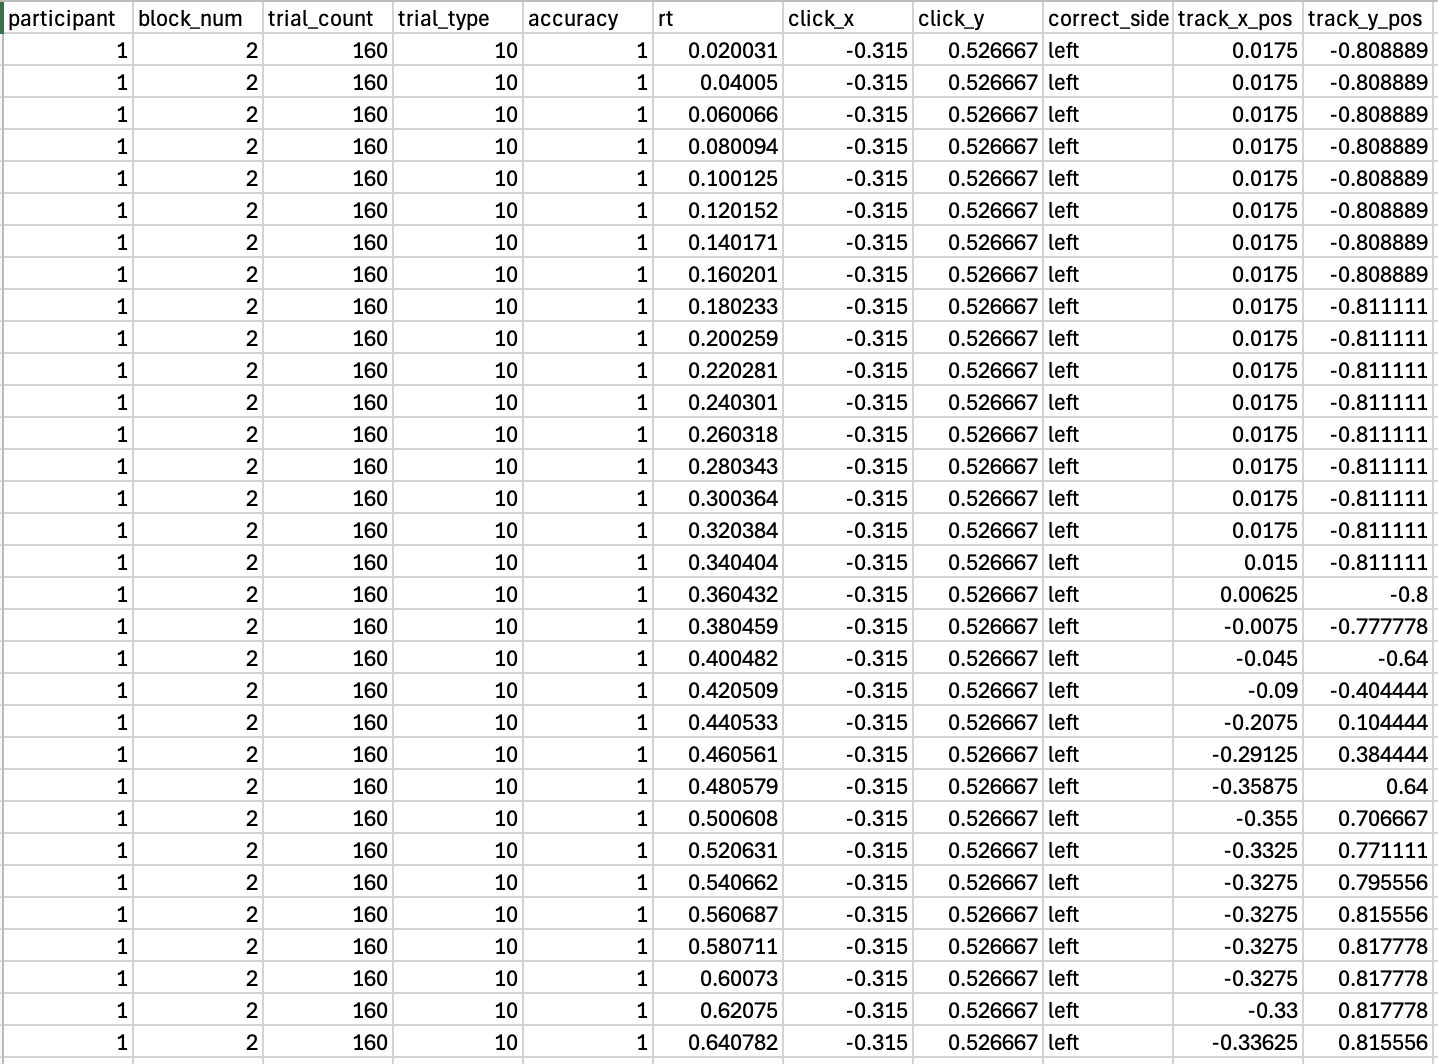

In [2]:
def create_master_spreadsheet():
    # Defining the paths
    runInfo_path = 'runInfo'
    clickData_path = 'clickData'
    trackAllData_path = 'trackAllData'

    # Creating a space for the final spreadsheet
    master_data = []

    # Finding all files in the runInfo directory that end with .csv
    filenames = [f for f in os.listdir(runInfo_path) if f.endswith('.csv')]

    for filename in filenames:
        # Extracting participant number from filename
        participant_id = filename.split('_')[1].replace('.csv', '')

        # Constructing corresponding filenames
        click_filename = f'clickData_{participant_id}.csv'
        track_filename = f'trackAllData_{participant_id}.csv'

        # Loading the files
        info_df = pd.read_csv(os.path.join(runInfo_path, filename))
        click_df = pd.read_csv(os.path.join(clickData_path, click_filename))
        track_df = pd.read_csv(os.path.join(trackAllData_path, track_filename))

        # Adding a column for the participant based on the I.D. we extracted earlier
        for df in [info_df, click_df, track_df]:
            df['participant'] = participant_id

        # Standardizing the column names
        info_df.rename(columns={
            'trialNum': 'trial_count',
            '# blockNum': 'block_num',
            'trialType': 'trial_type',
        }, inplace=True)

        click_df.rename(columns={
            'trialCt': 'trial_count',
            'pos_x': 'click_x',
            'pos_y': 'click_y'
        }, inplace=True)

        track_df.rename(columns={
            'trialCt': 'trial_count',
            'pos_x': 'track_x_pos', 
            'pos_y' : 'track_y_pos'
        }, inplace=True)

        # Merging the dataframes
        merged_df = pd.merge(track_df, info_df[['trial_count', 'block_num', 'trial_type']], on='trial_count', how='left')
        merged_df = pd.merge(merged_df, click_df[['trial_count', 'accuracy', 'click_x', 'click_y']], on='trial_count', how='left')

        # Creating a new column for which side the correct stimulus was on
        last_row_with_accuracy = pd.merge( # Factors in the accuracy boolean from clickData to check if the participant clicked the correct stimulus
        click_df[['trial_count', 'click_x']], click_df[['trial_count', 'accuracy']], on='trial_count', how='left')

        # Logic for deciding which side correct stimulus is on
        def determine_correct_stim_location(row):
            if row['accuracy'] == 1: 
                if row['click_x'] < 0: # If x is negative, correct stimulus is on the left
                    return 'left'
                elif row['click_x'] > 0: # If x is positive, correct stimulus is on the right
                    return 'right'
            if row['accuracy'] == 0:
                if row['click_x'] < 0: # If wrong x is negative, correct side must be right
                    return 'right'
                elif row['click_x'] > 0: # If wrong x is positive, correct side must be left
                    return 'left'
            else:
                return 'unknown'

        last_row_with_accuracy['correct_side'] = last_row_with_accuracy.apply(determine_correct_stim_location, axis=1)

        # Merging data frames
        merged_df = pd.merge(merged_df, last_row_with_accuracy[['trial_count', 'correct_side']], on='trial_count', how='left')

        # Filtering for blocks 2 and 7
        merged_df = merged_df[merged_df['block_num'].isin([2, 7])]

        # Adding merged data frame to the master list
        master_data.append(merged_df)

    # Concatenating all the participant data
    master_df = pd.concat(master_data, ignore_index=True)

    # Keeping relevant columns
    columns_to_keep = ['participant', 'block_num', 'trial_count', 'trial_type', 'accuracy', 'rt', 'click_x', 'click_y', 'correct_side', 'track_x_pos', 'track_y_pos']
    all_mouse_columns = [col for col in master_df.columns if any(x in col for x in ['track_x_pos', 'track_y_pos', 'rt'])]
    final_columns = list(set(columns_to_keep + all_mouse_columns))
    final_df = master_df[final_columns]

    # Dropping any unwanted columns
    final_df.drop(columns=[
        'prefix', 'group type1', 'group type 2', 'Participant_x', 'participant_x',
        'participant_y', 'rt1', 'rt2', 'pos_x_x', 'pos_y_x', 'rt3', 'pos_x.1',
        'pos_y.1', 'which_left'
    ], errors='ignore', inplace=True)

    # Ensuring the participant type is 'int'
    final_df['participant'] = pd.to_numeric(final_df['participant'], errors='coerce')
    final_df['trial_count'] = pd.to_numeric(final_df['trial_count'], errors='coerce')
    final_df['block_num'] = pd.to_numeric(final_df['block_num'], errors='coerce')

    # Sorting the spreadsheet
    final_df = final_df.sort_values(by=['participant', 'block_num', 'trial_count'])

    # Reordering the columns
    desired_order = ['participant', 'block_num', 'trial_count', 'trial_type', 'accuracy', 'rt', 'click_x', 'click_y', 'correct_side', 'track_x_pos', 'track_y_pos']
    
    # Creating the final data frame
    final_df = final_df[[col for col in desired_order if col in final_df.columns]]

    # Saving the final data frame to a CSV file
    final_df.to_csv('output/master_spreadsheet.csv', index=False)
    
    return final_df

# Showing a screenshot of what the final file looks like in Excel
Image(filename='images/final_df.png', width=800)

***
## Step 2: 
### Flip each mousetracking trajectory to be on one side to simplify analysis. 
***
In order to make things easier, we're flipping each correct mouse trajectory to be on the same side.

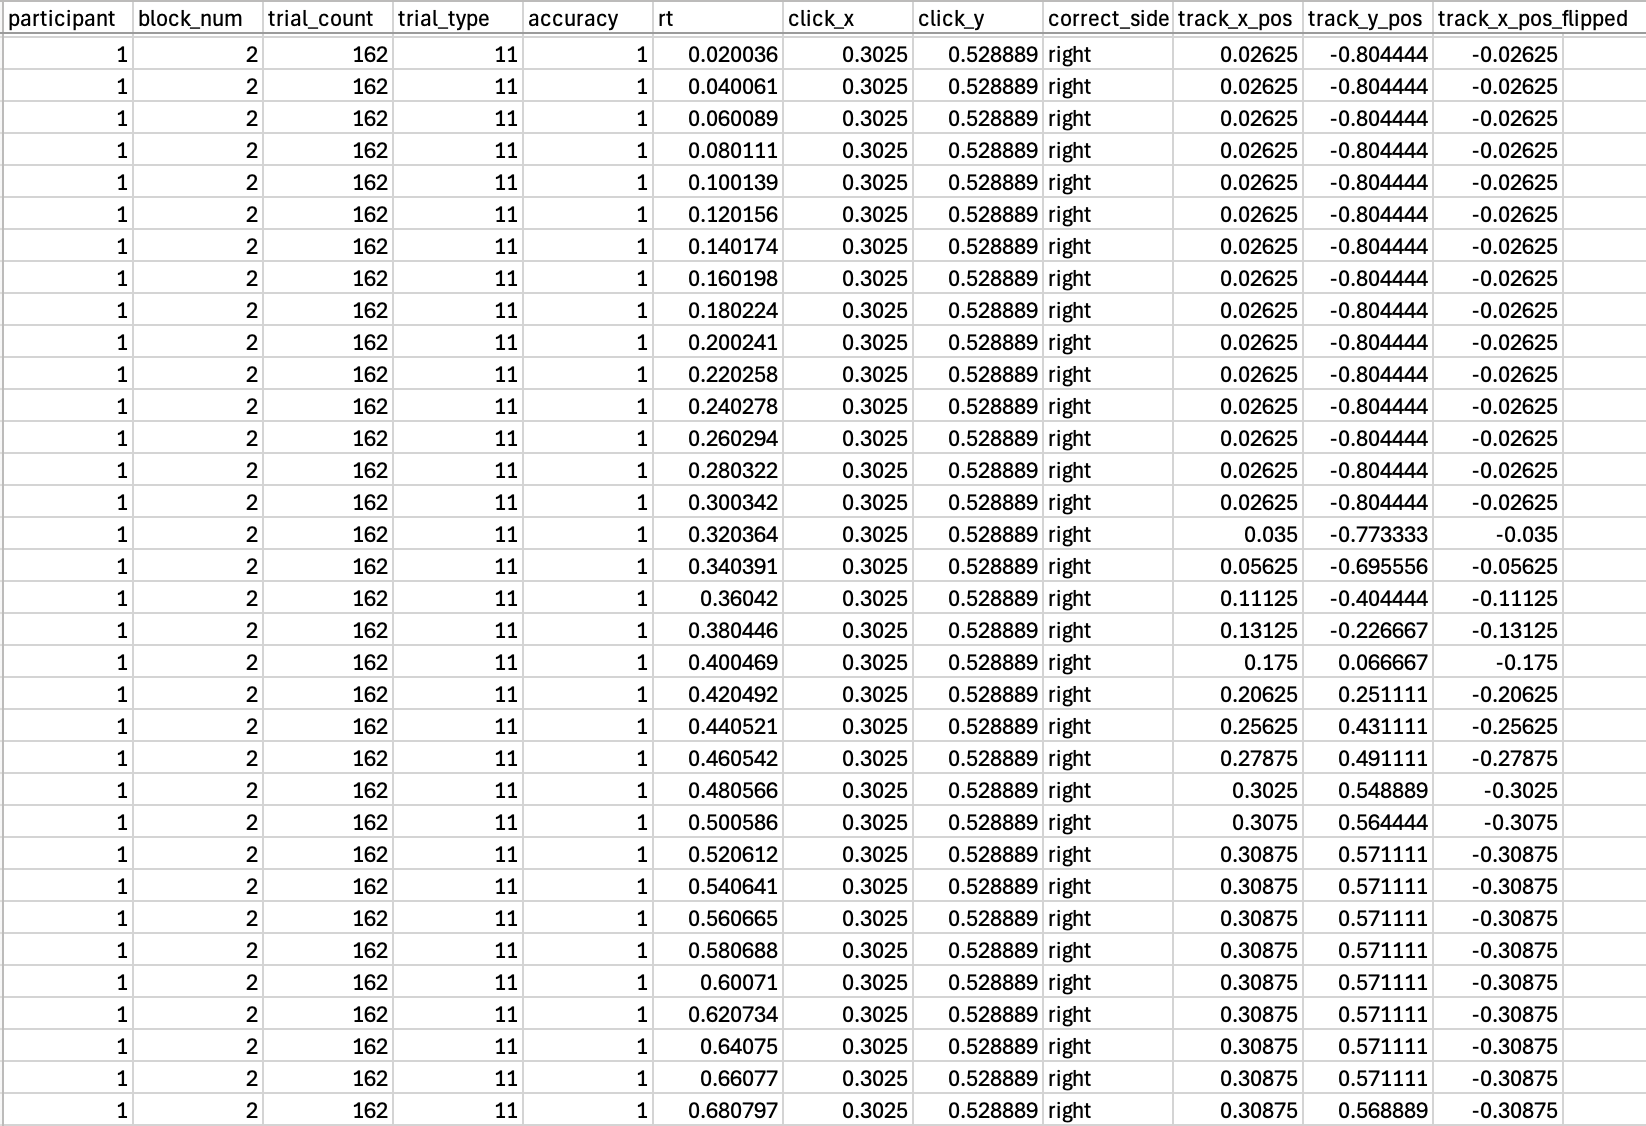

In [3]:
final_df = create_master_spreadsheet()

def find_flipped_x_trajectory(df):
    df.copy() # Copying over our data frame we made earlier
    
    df['track_x_pos_flipped'] = df.apply(
        lambda row: -row['track_x_pos'] if row['correct_side'] == 'right' else row['track_x_pos'],
        axis=1 # Since we want to move all trajectories to the left side, this part is making the x-values negative if they're on the right side. Otherwise, we keep it where it is
    )
    return df

# Creating a new data frame with all the same stuff from earlier, except an added column for the flipped x-values 
final_df_flipped = find_flipped_x_trajectory(final_df)

# Saving the new data frame to a csv file
final_df_flipped.to_csv('output/flipped_master_spreadsheet.csv', index=False)

# Showing a screenshot of what the final file looks like in Excel
Image(filename='images/final_df_flipped.png', width=800)

***
## Step 3: 
### Create plots of the x and y positions of the mouse during trial type 11 and Blocks 2 and 7 (the testing phases)
We're focusing on trial type 11 because it's our the target trial type. It's where the participant hears the exception word, and it tests how much they're lured by the generalization. The participant's mouse will go to a set correct choice for all trials.  

This function will allow us to look at the individual trajectories from Blocks 2 and 7. Lines from Block 2 will be in teal and lines from Block 7 will be in salmon (because I like alliteration).
***

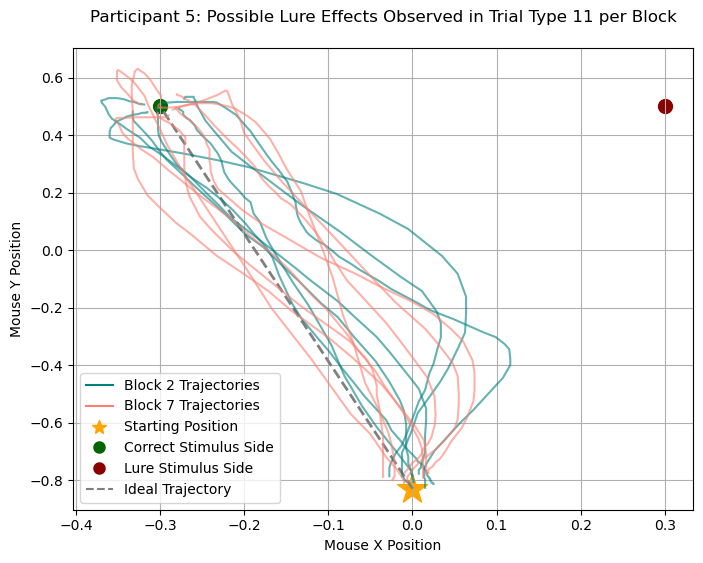

In [4]:
def plot_lure_effect_per_block(df, participant_id):
    # Making sure we're only looking at the trial type, block numbers, participant, and accuracy we want  
    df_filtered = df[(df['trial_type'] == 11) & (df['block_num'].isin([2, 7])) & (df['participant'] == participant_id) & (df['accuracy'] == 1)]

    # Creating the plot
    plt.figure(figsize=(8, 6))
    plt.title(f'Participant {participant_id}: Possible Lure Effects Observed in Trial Type 11 per Block\n')
    plt.xlabel('Mouse X Position')
    plt.ylabel('Mouse Y Position')

    # Using markers for the start, where the correct stimulus is, and where the lure stimulus is
    plt.scatter(0, -0.83, color='orange', s=500, marker='*', label='Starting Position')
    plt.scatter(-0.3, 0.5, color='darkgreen', s=100, label='Correct Stimulus Side')
    plt.scatter(0.3, 0.5, color='darkred', s=100, label='Lure Stimulus Side')

    # Adding theh perfect line straight to the correct stimulus
    plt.plot([0, -0.3], [-0.83, 0.5], color='gray', linestyle='--', linewidth=2, label='Ideal Trajectory')

    # Disregarding any duplicate data if there is any
    unique_trials = df_filtered.drop_duplicates(subset=['trial_count'])

    # Goes through each participant and trial
    for _, row in unique_trials.iterrows():
        trial_id = row['trial_count']
        trial_data = df_filtered[(df_filtered['participant'] == participant_id) & (df_filtered['trial_count'] == trial_id)]

        # Ignoring any empty data, if there is any
        if trial_data.empty:
            continue

        # Pulling x and y values from the spreadsheet
        x = trial_data['track_x_pos_flipped'].values
        y = trial_data['track_y_pos'].values

        # Color coding the lines. Block 2 lines are colored teal, block seven lines are colored salmon
        color = 'teal' if row['block_num'] == 2 else 'salmon'
        plt.plot(x, y, alpha=0.6, color=color)

    # Creating the legend
    block2_line = mlines.Line2D([], [], color='teal', label='Block 2 Trajectories')
    block7_line = mlines.Line2D([], [], color='salmon', label='Block 7 Trajectories')
    plt.legend(handles=[block2_line, block7_line, mlines.Line2D([], [], color='orange', marker='*', linestyle='None', markersize=10, label='Starting Position'), mlines.Line2D([], [], color='darkgreen', marker='o', linestyle='None', markersize=8, label='Correct Stimulus Side'), mlines.Line2D([], [], color='darkred', marker='o', linestyle='None', markersize=8, label='Lure Stimulus Side'), mlines.Line2D([], [], color='gray', linestyle='--', label='Ideal Trajectory')], loc='lower left')

    plt.grid(True)
    plt.show()

plot_lure_effect_per_block(final_df_flipped, participant_id = 5)



***
## Step 4: 
### Create plots of the average mouse trajectories during blocks 2 and 7 (the testing phases) using interpolation
Now we're going to plot the *average* mouse trajectories of Blocks 2 and 7, because our initial graphs with all the lines on top of each other are pretty messy. If we plot the averages, we can simplify things by just using two lines for our analyses. 

We'll have to use interpolation for this, but what actually is interpolation? 

We might not have the same number of timepoints in each trajectory per trial, because each participant has different reaction times. Interpolation allows us to calculate estimated values between the real points we already have so we can create smooth, consistent lines for each trial. This is needed to create an average plot for our graphing purposes.
***

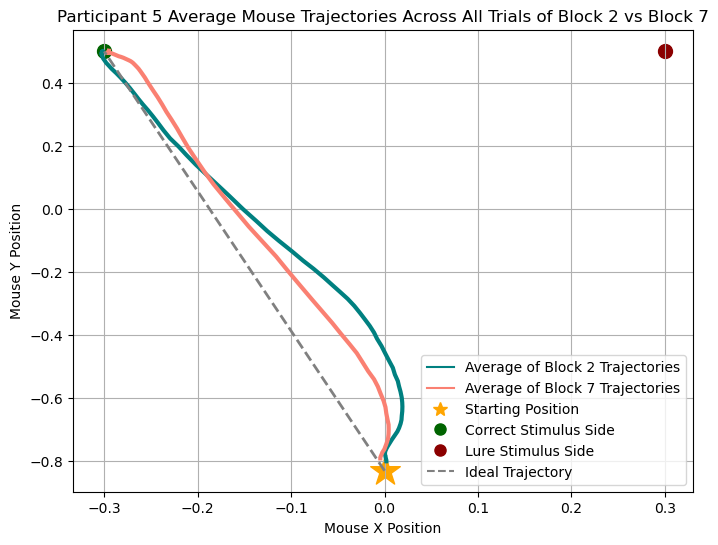

In [5]:
def plot_average_trajectories(df, participant_id, num_points=100):
    # Making sure we're only looking at the trial type, block numbers, participant, and accuracy we want  
    df_filtered = df[(df['trial_type'] == 11) & (df['block_num'].isin([2, 7])) & (df['participant'] == participant_id) & (df['accuracy'] == 1)]

    # Disregarding any duplicate data if there is any
    unique_trials = df_filtered[df_filtered['participant'] == participant_id].drop_duplicates(subset=['trial_count'])

    # Setting up spaces to store the interpolated trajectories for each block
    interpolated_data = {2: {'x': [], 'y': []}, 7: {'x': [], 'y': []}}

    # Going through each participant and trial
    for _, row in unique_trials.iterrows():
        trial_id = row['trial_count']
        participant_id = row['participant']
        block = row['block_num']

        # Extracting the full actual trajectories per trial
        trial_data = df_filtered[(df_filtered['participant'] == participant_id) & (df_filtered['trial_count'] == trial_id)]

        x = trial_data['track_x_pos_flipped'].values
        y = trial_data['track_y_pos'].values

        # Normalizing the timepoints from 0 seconds 1 second
        t_original = np.linspace(0, 1, len(x))
        t_interp = np.linspace(0, 1, num_points)

        # Interpolating the data
        interp_x = interp1d(t_original, x, kind='linear')(t_interp)
        interp_y = interp1d(t_original, y, kind='linear')(t_interp)

        # Storing the interpolated data
        interpolated_data[block]['x'].append(interp_x)
        interpolated_data[block]['y'].append(interp_y)

    # Creating the plot
    plt.figure(figsize=(8, 6))
    plt.title(f'Participant {participant_id} Average Mouse Trajectories Across All Trials of Block 2 vs Block 7')
    plt.xlabel('Mouse X Position')
    plt.ylabel('Mouse Y Position')

    # Plotting reference points
    plt.scatter(0, -0.83, color='orange', s=500, marker='*', label='Starting Position')
    plt.scatter(-0.3, 0.5, color='darkgreen', s=100, label='Correct Stimulus Side')
    plt.scatter(0.3, 0.5, color='darkred', s=100, label='Lure Stimulus Side')

    # Plotting average trajectories for each block
    for block, color in zip([2, 7], ['teal', 'salmon']):
        if interpolated_data[block]['x']:
            mean_x = np.mean(interpolated_data[block]['x'], axis=0)
            mean_y = np.mean(interpolated_data[block]['y'], axis=0)
            plt.plot(mean_x, mean_y, color=color, linewidth=3, label=f'Block {block} Average Trajectory')

    # Drawing a straight reference line from start to correct stimulus side
    plt.plot([0, -0.3], [-0.83, 0.5], color='gray', linestyle='dashed', linewidth=2, label='Hypothetical Ideal Trajectory')

    # Creating the legend
    block2_line = mlines.Line2D([], [], color='teal', label='Average of Block 2 Trajectories')
    block7_line = mlines.Line2D([], [], color='salmon', label='Average of Block 7 Trajectories')
    plt.legend(handles=[block2_line, block7_line, mlines.Line2D([], [], color='orange', marker='*', linestyle='None', markersize=10, label='Starting Position'), mlines.Line2D([], [], color='darkgreen', marker='o', linestyle='None', markersize=8, label='Correct Stimulus Side'), mlines.Line2D([], [], color='darkred', marker='o', linestyle='None', markersize=8, label='Lure Stimulus Side'), mlines.Line2D([], [], color='gray', linestyle='--', label='Ideal Trajectory')], loc='lower right')

    plt.grid(True)
    plt.show()

plot_average_trajectories(final_df_flipped, participant_id = 5)


***
## Step 5: 
### Calculate the areas under the curve
Now that we have our average trajectories per block, we're going to calculate the area under the curve (ie. how much deviation there is compared to the straight line that would occur if the participant were to go straight towards the stimulus without hestitation/being influenced by the lure stimulus). The more deviation towards the lure stimulus there is, the more we can assume the generalization is still affecting the user's choices. 

Our hypothesis predicts that the area under the curve should decrease over time as the exceptions beat out the generalizations in competition. 

While this is by no means an exact mathematical measurement, the images below provide a visual representation of what we're measuring. As you can see here, the area under the curve (at least for participant 5) looks a lot smaller in Block 7 versus in Block 2, which is exactly the result we're hoping to observe among the other participants.   

<p style="display: flex; gap: 10px;">
  <img src="./images/teal_AUC.png" alt="Teal AUC" width="650"/>
  <img src="./images/salmon_AUC.png" alt="Salmon AUC" width="650"/>
</p>


***

In [6]:
def calculate_average_area_under_curve(df, participant_id = 5):
    # Creating a dictionary to store our calculated results
    auc_results = {}
    # Defining which blocks we're going to be using
    blocks = [2, 7]

    # Looping through Blocks 2 and 7
    for block in blocks:
        # Making sure we're only looking at the trial type, block numbers, participant, and accuracy we want  
        df_filtered = df[(df['trial_type'] == 11) & (df['block_num'] == block) & (df['participant'] == participant_id) & (df['accuracy'] == 1)]

        # Getting a list of unique trials for each block
        trial_ids = df_filtered['trial_count'].unique()

        # Creating spaces for the interpolated x and y positions
        interpolated_x = []
        interpolated_y = []

        # Looping through each trial
        for trial in trial_ids:
            trial_data = df_filtered[df_filtered['trial_count'] == trial]
            # Ignoring any empty data if there is any
            if trial_data.empty:
                continue

            # Pulling the trajectory x and y values from the spreadsheet
            x = trial_data['track_x_pos_flipped'].values
            y = trial_data['track_y_pos'].values

            # Interpolating the data by standardizing everything with 100 timepoints
            try:
                interp_x = interp1d(np.linspace(0, 1, len(x)), x)(np.linspace(0, 1, 100))
                interp_y = interp1d(np.linspace(0, 1, len(y)), y)(np.linspace(0, 1, 100))
                interpolated_x.append(interp_x)
                interpolated_y.append(interp_y)
            except Exception:
                continue

        # Ensuring we're only using data that has been interpolated
        if not interpolated_x or not interpolated_y:
            auc_results[block] = None
            continue

        # Finding the average interpolation trajectory across all trials
        avg_x = np.mean(interpolated_x, axis=0)
        avg_y = np.mean(interpolated_y, axis=0)

        # Finding the AUC 
        auc = simpson(np.abs(avg_x), avg_y)
        auc_results[block] = auc
        

    # Computing the difference to make analysis easer. A positive result means that the difference is greater in Block 2 than in Block 7 (what we want), and a negative result means that the difference is greater in Block 7 than it is in Block 2 
    auc_difference = None
    if auc_results.get(2) is not None and auc_results.get(7) is not None:
        auc_difference = auc_results[2] - auc_results[7]

    return {
        'AUC: Block 2': auc_results.get(2),
        'AUC: Block 7': auc_results.get(7),
        'AUC Difference': auc_difference
    }


calculate_average_area_under_curve(final_df_flipped, participant_id = 5)


{'AUC: Block 2': 0.1505459252395855,
 'AUC: Block 7': 0.15711454725880653,
 'AUC Difference': -0.006568622019221038}

***
## Step 6: 
### Do this for all participants and analyze the results
So far, we've been doing this for one participant only (participant 5). Let's do it with all 42 participants and see what we find!
***

In [7]:
def calculate_auc_averages_all_participants(df):
    # Defining containers to store our results
    participant_results = {}
    block_2_AUCs = []
    block_7_AUCs = []
    auc_diffs = []

    # Looping through each unique participant
    for participant_id in df['participant'].unique():
        auc_data = calculate_average_area_under_curve(df, participant_id)
        
        participant_results[participant_id] = {
            'block_2_auc': auc_data.get('AUC: Block 2'),
            'block_7_auc': auc_data.get('AUC: Block 7'),
            'auc_diff': auc_data.get('AUC Difference')
        }

        # Collecting values for averages
        block_2_AUCs.append(auc_data.get('AUC: Block 2'))
        block_7_AUCs.append(auc_data.get('AUC: Block 7'))
        auc_diffs.append(auc_data.get('AUC Difference'))

    # Computing group averages
    avg_block_2_auc = np.mean(block_2_AUCs)
    avg_block_7_auc = np.mean(block_7_AUCs)
    avg_auc_diff = np.mean(auc_diffs)

    # Creating a datarame for participant-level data
    participant_df = pd.DataFrame.from_dict(participant_results, orient='index')
    participant_df.index.name = 'Participant'

    # Creating a DataFrame for group-level averages
    group_df = pd.DataFrame([{
        'Average AUC: Block 2': avg_block_2_auc,
        'Average AUC: Block 7': avg_block_7_auc,
        'Average AUC Difference': avg_auc_diff
    }], index=['Group Averages'])

    return participant_df, group_df

participant_df, group_df = calculate_auc_averages_all_participants(final_df_flipped)

# Displaying the data
display(participant_df)
display(group_df)


,block_2_auc,block_7_auc,auc_diff
Participant,,,
1,0.144979,0.189029,-0.044050
2,0.250145,0.129622,0.120523
3,0.119414,0.185606,-0.066192
4,0.205282,0.213472,-0.008190
5,0.150546,0.157115,-0.006569
6,0.161121,0.168533,-0.007412
7,0.181427,0.188939,-0.007512
8,0.069528,0.118193,-0.048666
9,0.047088,0.141692,-0.094604


,Average AUC: Block 2,Average AUC: Block 7,Average AUC Difference
Group Averages,0.139921,0.158418,-0.018497


***
## Step 7: 
### Determine the statistical significance of the average AUC difference result
In order to determine how likely it is this result was due to chance, I'm going to perform a simple t-test to derive a p-value. 
***

In [8]:
def determine_statistical_significance(df):
    # Making containers for the average AUCs of each block
    block2 = []  
    block7 = []  

    # Looping through each unique participant
    for participant_id in df['participant'].unique():
        auc_data = calculate_average_area_under_curve(df, participant_id)
        
        block2.append(auc_data.get('AUC: Block 2'))
        block7.append(auc_data.get('AUC: Block 7'))

    # Using a paired t-test 
    t_stat, p_value = stats.ttest_rel(block7, block2)

    print("t-statistic:", t_stat)
    print("P-value:", p_value)

determine_statistical_significance(final_df_flipped)

t-statistic: 2.2455288021851945
P-value: 0.030188270761382176


In [9]:
def main():
    global final_df, final_df_flipped
    final_df = create_master_spreadsheet()
    final_df_flipped = find_flipped_x_trajectory(final_df)

main()


***
## Final Analysis: 
Based on the final p-value, we can assume that there is about a 3% chance that these results would have happened by chance. Unfortunately, this result means that we can't reject the null hypothesis, meaning our initial hypothesis was disproven. However, this does not necessarily mean the *idea* was wrong. My first guess is that the sample size was too small, and we would perhaps observe different results if we had a larger sample size. 

Either way, this study defines a detailed investigation of memory-related cognitive mechanisms, and certainly warrants further exploration. 
***